In [1]:
# Import necissary packages

import math
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import datetime
from statsmodels import robust
import matplotlib as mpl
from matplotlib import gridspec
import pylab
from matplotlib import cm
from pytz import timezone

# Sky Area & Time Jupyter Notebook

## Summary

In this notebook, we will use obeservation logs from each night to calculate the total amount of time that we observed the sky for fireballs.

## Sections:

* ### [Analyzing Observation Logs](#obs)
    * [Calculating total time](#time)
    
    
* ### [Cloud Analysis](#cloud)
    * [What area of sky are we seeing?](#sodt)

# Analyzing Observation Logs <a name="obs"></a>


The main goal is to end up with a table that includes information about how much time we spend observing each night.

## Calculating total time  <a name="time"></a>

Here we use the observation log to meet our goals as described above

In [2]:
# List directory contents and create list of avi videos

vidpath = '/home/pj/UsbStick/'

#Load document
obs = np.loadtxt(vidpath+'Observation_Log.txt', dtype=str, delimiter=']: ')

# Clean up format
for i in np.arange(0,len(obs)):
    obs[i,0] = obs[i,0][1:20]

# Look at starting and stopping notes
cond_startstop = (#(obs[:,1]=='New Observation Run Started')|
                  (obs[:,1]=='Observing session finished.')|
                  (obs[:,1]=='Day has come. Analysis going to sleep.')|
                 (obs[:,1]=='A new night has arrived! Frame analysis beginning!'))

# Enact condition we just defined
startstop = (obs[cond_startstop])

##########################
# Create array of start time, end time, and time difference (seconds)
##########################

# create array as long as start times
char = np.chararray((len(startstop[startstop[:,1]=='A new night has arrived! Frame analysis beginning!']),3),itemsize=40)

# set initial index
m=0


for i in np.arange(0,len(startstop)):
    comment = startstop[i,1]
    # look for specific comment
    if comment == 'A new night has arrived! Frame analysis beginning!':
        # if it's true, look for next time and record both
        date = startstop[i,0]
        next_date = startstop[i+1,0]
        
        # use datetime functions to find time difference
        strip1 = datetime.datetime.strptime(date,'%Y/%m/%d %H:%M:%S')
        strip2 = datetime.datetime.strptime(next_date,'%Y/%m/%d %H:%M:%S')
        tdif = strip2-strip1
        tdif_seconds = tdif.seconds
        
        # append information to empty array and increase index by 1
        char[m] = date,next_date,tdif_seconds
        m += 1
        
# Get rid of pesky "b''" problem
char = char.decode('utf-8')

# Presenet information as pandas array
t1_t2_tdif = pd.DataFrame(char, columns=('Time1', 'Time2', 'Tdif (seconds)'))

t1_t2_tdif.to_csv('start_end_observations.csv',index=False)

,Time1,Time2,Tdif (seconds)
0,2018/08/12 22:00:02,2018/08/13 05:00:00,25198
1,2018/08/13 18:56:57,2018/08/13 18:57:38,41
2,2018/08/13 22:00:01,2018/08/14 05:00:00,25199
3,2018/08/18 22:00:01,2018/08/19 05:00:00,25199
4,2018/08/19 22:00:00,2018/08/20 05:00:00,25200
5,2018/08/27 22:00:02,2018/08/28 05:00:00,25198
6,2018/08/28 22:00:03,2018/08/29 05:00:00,25197
7,2018/09/20 22:00:02,2018/09/21 05:00:00,25198
8,2018/09/22 21:00:01,2018/09/23 05:00:00,28799
9,2018/09/23 21:00:02,2018/09/24 05:00:00,28798


# Cloud Analysis  <a name="cloud"></a>

Here we delve into the all photos taken by the camera.  We used histograms to determine what cutoff we should use.  To get the methods we attained in this section we did the following:

* Plotted up histograms of black and white converted images
* Found the median value of each histogram and looked for plots with high medians
* Identified a threshold of 75 that seemed fitting

In [6]:
# List directory contents and create list of avi videos
vidpath = '/home/pj/UsbStick/Video/'
dircontents = np.array(os.listdir(vidpath))

# Look at specific directory and scan it for png images
cond = [(file[-4:] == '.png') for file in dircontents]
onlypics = dircontents[cond]

#data = np.loadtxt('cloud_days.txt', dtype=str) 
#cond09 = np.invert([onlypics[i] in np.unique(np.array(data)[:,0]) for i in np.arange(0,len(onlypics))])
#onlypics = onlypics[cond09]

# Sort by date most recent
in_order = sorted(onlypics, key=lambda x: datetime.datetime.strptime(x, '%Y%m%d_%H%M%S_Snap.png'))
onlypics = in_order[::-1]
len(onlypics)

561

In [7]:
# Load angdist/pixel document [ratio, xloc, yloc]
star_ratios = np.loadtxt('loc_and_ratios.txt')

# Find center of data
midpoint = (720/2,480/2)

# Loop of angles to rotate through
rads = np.arange(0,2*np.pi,np.deg2rad(5))

empty = []

for i in np.arange(0,len(rads)):
    # rotate original by ang radians
    ang = rads[i]
    
    # Make everything centered at (0,0)
    xs = star_ratios[:,1]-midpoint[0]
    ys = star_ratios[:,2]- midpoint[1]
    
    # Rotation matrix!
    rota = [[np.cos(ang), -np.sin(ang)],[np.sin(ang),np.cos(ang)]]
    mul = np.matmul(rota,[xs,ys])
    trans = np.transpose(mul)
    
    # Move things back to way they were
    xs2 = trans[:,0]+midpoint[0]
    ys2 = trans[:,1]+midpoint[1]
    
    # Append to array
    rotated_group = np.column_stack((star_ratios[:,0],xs2,ys2))
    if i == 0:
        all_rotated_copies = rotated_group
    else:
        all_rotated_copies = np.vstack((all_rotated_copies,rotated_group))
    

In [8]:
# Only care about data points that fall within our camera pixel regions

cond1 = (all_rotated_copies[:,1]>=0)&(all_rotated_copies[:,1]<=720)
cond2 = (all_rotated_copies[:,2]>=0)&(all_rotated_copies[:,2]<=480)
cond12 = cond1&cond2

71.55208333333333

In [9]:
# Here we make the different squares have different ratio values

# This inc can be changed to make squares different sized
inc = 40
xdivs = np.arange(0,720+inc,inc)
ydivs = np.arange(0,480+inc,inc)
ydivs = ydivs[::-1]

# Create empty array
empty = np.zeros((len(ydivs)-1,len(xdivs)-1))

# Look in each square region
for i in np.arange(0,len(xdivs)-1):
    left = xdivs[i]
    right = xdivs[i+1]
    for j in np.arange(0,len(ydivs)-1):
        bottom = ydivs[j+1]
        top = ydivs[j]
        
        # Look at all data points within x and y bounds
        cond_x = ((all_rotated_copies[:,1] >= left)&(all_rotated_copies[:,1] < right))
        cond_y = ((all_rotated_copies[:,2] >= bottom)&(all_rotated_copies[:,2] < top))
        cond_both = (cond_x&cond_y)
        subset = all_rotated_copies[cond_both]
        
        # If anything is in there, average the ratios and append to empty array
        if len(subset) > 0:
            empty[j,i] = np.average(subset[:,0])
        else:
            empty[j,i] = 0

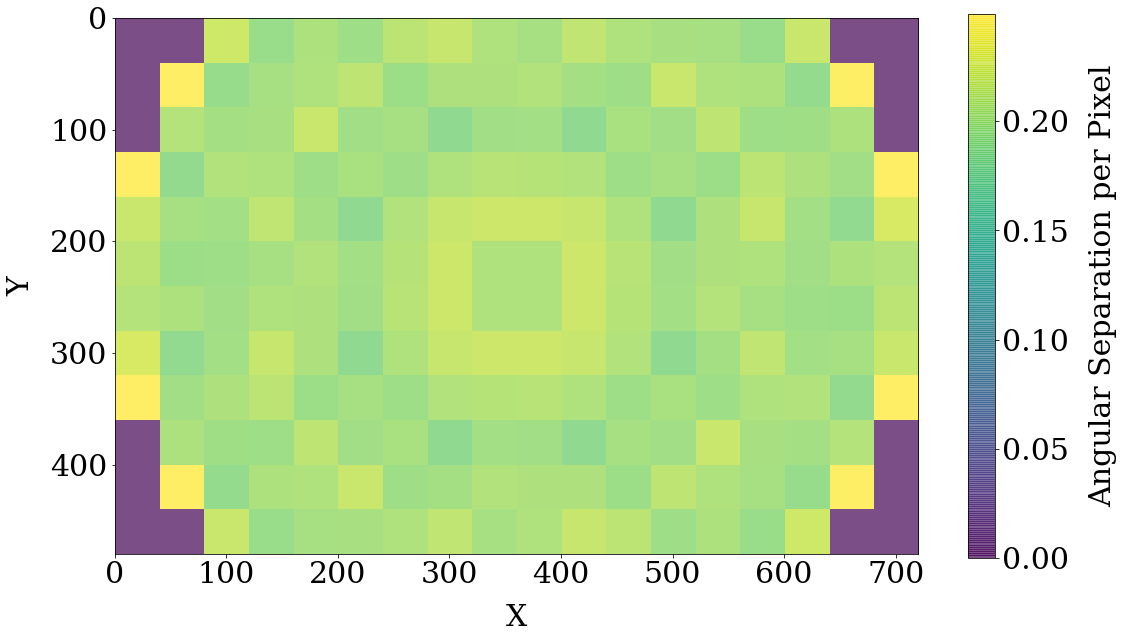

In [12]:
### plot of ratios with colorbar!!

fig = plt.figure(figsize=(18,10))
ax3 = plt.subplot(1,1,1)

#plt.imshow(pic, cmap='gray')

plt.imshow(empty,
           cmap = 'viridis', #setting the color map
           origin = 'lower', # IMPORTANT, or else the upper left will be your origin!
           extent = [0,720,480,0], # imshow doesn't know the boundaries otherwise
           alpha=0.7
          )

color_bar = plt.colorbar()
#plt.scatter(all_rotated_copies[:,1],all_rotated_copies[:,2], color='white', s=1)


plt.xlim(0,720)
plt.ylim(480,0)

cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')                #tricky
plt.setp(cbytick_obj, color='black')

plt.ylabel('Y', labelpad=15,fontsize=30)
color_bar.set_label('Angular Separation per Pixel', labelpad=20, color='black')
pylab.rc('font', family='serif', size=30)
plt.xlabel('X', labelpad=15, fontsize=30)

#fig.patch.set_facecolor('black')
#ax3.spines['bottom'].set_color('white')
#ax3.spines['top'].set_color('white')
#ax3.spines['left'].set_color('white')
#ax3.spines['right'].set_color('white')
#ax3.xaxis.label.set_color('white')
#ax3.tick_params(axis='x', colors='white')
#ax3.yaxis.label.set_color('white')
#ax3.tick_params(axis='y', colors='white')

#fig.savefig('images/Cloud_analysis_white3.png', facecolor=fig.get_facecolor(), transparent=True)


plt.show()

#fig.savefig('images/boxes_colored.png', facecolor=fig.get_facecolor(), transparent=True, bbox_inches='tight')

## Calculating Real Total Observable Area (round F.O.V.)

In [47]:
# For plotting later
coolempty = np.zeros(pic.shape)

# Identify pic that is completely cloudy
pic = cv2.imread(path+'20180924_113453_Snap.png')
    
# Convert to grayscale
pic = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    
# Threshold it at 40
ret3,th3 = cv2.threshold(pic,90,255,cv2.THRESH_BINARY)
    
# Use 5x5 kernal in morpohology close and erode
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    
# Close up any small gaps in clouds and then open back up other areas
closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel, iterations=1)
opening = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=1)
    
# Initialize sum of angular distance covered by clouds
sum_angdist = 0
for j in np.arange(0,len(opening)):
    for k in np.arange(0,len(opening[0])):
        # If we have a 'cloud pixel' ---> do stuff
        if (opening[j,k] != 0):
            # Add contribution specific to respective small square
            box_x = divmod(k,40)[0]
            box_y = divmod(j,40)[0]
            cont = empty[box_y,box_x]
            coolempty[j,k] = cont
            
            # Use formulas to calcualte rectangular solid angle area
            cont_rad = np.deg2rad(cont)
            cont_solid_ang = 4*np.arcsin(np.sin(cont_rad/2)**2)
            contribution = cont_solid_ang*alt_atmosphere**2
            sum_angdist += contribution
            
            
total_area = sum_angdist

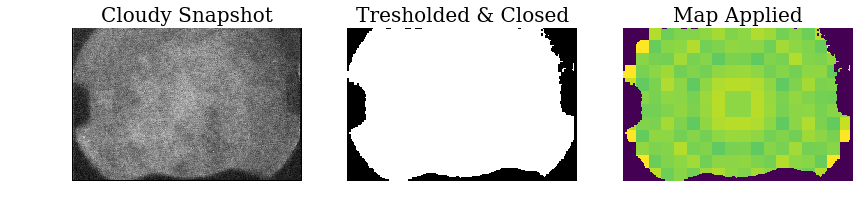

In [48]:
# Nice plot of area

fig = plt.figure(figsize=(14,7))

plt.subplot(131)
plt.imshow(pic,cmap='gray')
plt.title('Cloudy Snapshot',fontsize=20)
plt.axis('off')
plt.subplot(132)
plt.title('Tresholded & Closed',fontsize=20)
plt.imshow(opening,cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.title('Map Applied',fontsize=20)
plt.imshow(coolempty,cmap='viridis')
plt.axis('off')

plt.show()

In [49]:
#####################################################################
# Calculate total area of sky coverage!
##################################
###################################

'''
(1) Steradian = 4*arcsin(sin(a/2)*sin(b/2))

where a, b are angular distances of rectangular pyriamid side lengths
-> in our case a=b=angular_sep_per_pixel

* Multipy by 40 for our box sizes in the above graph


---------------------------------------------------------------------

(2) Area = Steradian * r^2

where r is the height above observer

'''


# Convert angular seperation per pixel to radians
empty_rad = np.deg2rad(empty)

# Use equation (1) above
solid_ang = 4*np.arcsin(np.sin(empty_rad*40/2)**2)

# Got this height from table in [HGB96] reference of Luke's paper
# It is the highest initial height.
alt_atmosphere = 114.0

# Use equation (2) above
box_areas = solid_ang*alt_atmosphere**2 #in km^2

# Sum over all the boxes
boxes_total_area = np.sum(box_areas)
boxes_total_area

54464.73983106365

### Create Table of Observable Area for each Night

Areas are given in $km^2$

In [73]:
clouds = np.loadtxt('cloud_days.txt', dtype='str')
existing_images = clouds[:,0]
#to_complete = onlypics
to_complete = np.array(list(set(list(onlypics))- set(list(existing_images))))

In [74]:
# Specify directory you want to pull from
path = vidpath

# Create empty array to fill [vidname, angdist covered by clouds]
fillme = np.chararray((len(to_complete),2), itemsize = 30)
fillme[:] = '0'


for i in np.arange(0,len(to_complete)):
    
    # Identify pic
    pic = cv2.imread(path+to_complete[i])
    
    # Convert to grayscale
    pic = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    
    # Threshold it at 90
    ret3,th3 = cv2.threshold(pic,90,255,cv2.THRESH_BINARY)
    
    # Use 5x5 kernal in morpohology close and erode
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    
    # Close up any small gaps in clouds and then open back up other areas
    closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel, iterations=1)
    opening = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=1)
    
    # Initialize sum of angular distance covered by clouds
    sum_angdist = 0
    for j in np.arange(0,len(opening)):
        for k in np.arange(0,len(opening[0])):
            # If we have a 'cloud pixel' ---> do stuff
            if (opening[j,k] != 0):
                # Add contribution specific to respective small square
                box_x = divmod(k,40)[0]
                box_y = divmod(j,40)[0]
                cont = empty[box_y,box_x]
                cont_rad = np.deg2rad(cont)
                cont_solid_ang = 4*np.arcsin(np.sin(cont_rad/2)**2)
                contribution = cont_solid_ang*alt_atmosphere**2
                sum_angdist += contribution
                
    area = total_area - sum_angdist
                
    # Append to array!
    fillme[i,0] = to_complete[i]
    fillme[i,1] = area
    
    #print(area)

# Get rid of pesky 'b""' problem
fillme = fillme.decode('utf-8')

In [76]:
# Append new data about cloudiness of nights to each file

if len(fillme)>0:
    file2 = open('cloud_days.txt','a')
    for i in np.arange(0,len(fillme)):
        file2.write(str(fillme[i,0])+'    '+str(fillme[i,1])+'\n')
    file2.close()
else:
    print('you\'ve already got them all')

you've already got them all


### Create table of time and coverage for each observation

In [77]:

# Establish path for videos/pics to be used in future
path = '/home/pj/Documents/Thesis/clouds/'


# Load info about each cloudy pic
cloud_info = np.loadtxt('cloud_days.txt', dtype=str)

# Reverse list so that it's from earlier times to later times
cloud_info = cloud_info[::-1]
name = cloud_info[:,0]
vals = cloud_info[:,1].astype(float)

# Load in start and endtimes document
startendz = np.array(pd.read_csv('start_end_observations.csv'))


# Convert video/pic name to datetime format
name_converted = [timezone('UTC').localize(datetime.datetime.strptime(name[j],'%Y%m%d_%H%M%S_Snap.png')) for j in np.arange(0,len(name))]


In [79]:
direcs = []
tot = 0
for i in np.arange(0,len(startendz)):
    # Pick start time
    start = startendz[i,0]
    start = datetime.datetime.strptime(start, '%Y/%m/%d %H:%M:%S')
    start = timezone('US/Pacific').localize(start)
    
    # Pick end time
    end = startendz[i,1]
    end = datetime.datetime.strptime(end, '%Y/%m/%d %H:%M:%S')
    end = timezone('US/Pacific').localize(end)
    
    first0 = startendz[i,0].split(' ')[0]
    first1 = first0.split('/')
    first2 = first1[0]+'-'+first1[1]+'-'+first1[2]
    
    second0 = startendz[i,1].split(' ')[0]
    second1 = second0.split('/')
    second2 = second1[0]+'-'+second1[1]+'-'+second1[2]
    
    
    cond1 = [(start<=name_converted[j]) for j in np.arange(0,len(name))]
    cond2 = [(end>name_converted[j]) for j in np.arange(0,len(name))]
    cond1 = np.array(cond1)
    cond2 = np.array(cond2)
    cond_both = cond1&cond2
    pics_in_range = np.array(name_converted)[cond_both]
    pics_in_range = sorted(pics_in_range)
    #tot += sum(cond_both) # Just a check to see if we file in all pics
    timerow = np.hstack((start.astimezone(timezone('UTC')),pics_in_range,end.astimezone(timezone('UTC'))))
    
    coverage_in_range = np.array(vals)[cond_both]
    coverage_row = np.hstack((0,coverage_in_range,0))
    
    spacing_row = []
    if len(timerow) >= 5:
        for j in np.arange(2,len(timerow)-2):
            left_gap = timerow[j]-timerow[j-1]
            right_gap = timerow[j+1]-timerow[j]
            gaps = ((left_gap.seconds)/2)+((right_gap.seconds)/2)
            spacing_row.append(gaps)
        spacing_row = np.array(spacing_row)
        
        beginning_left = (timerow[1]-timerow[0]).seconds
        beginning_right = (timerow[2]-timerow[1]).seconds/2
        beginning_gap = beginning_left+beginning_right
        
        end_right = (timerow[-1]-timerow[-2]).seconds
        end_left = (timerow[-2]-timerow[-3]).seconds/2
        end_gap = end_right+end_left
        
        last_row = np.hstack((0,beginning_gap,spacing_row,end_gap,0))
    else:
        last_row = np.zeros((len(timerow),))
        spacing_row = np.zeros((len(timerow),))
        
    
    time_and_coverage = pd.DataFrame(np.vstack((timerow,coverage_row,last_row)), index=(['timestamps', 'area_observed_(km^2)', 'time_with_coverage (seconds)']))

    file_name = first2+'_'+second2
    
    time_and_coverage.to_csv(path+file_name)

### Read in files containing time/coverage information

In [80]:
# Find total time observed and avg area for each month


# For total fluxes
all_areas =  []
total_time = 0

# See time for analysis without snapshots
weird_areas = []
weird_time = 0

# For individual month flux information
august_areas = []
august_time = 0

september_areas = []
september_time = 0

october_areas = []
october_time = 0

november_areas = []
november_time = 0

december_areas = []
december_time = 0

january_areas = []
january_time = 0

february_areas = []
february_time = 0

march_areas = []
march_time = 0

########################################################################

# List directory contents for cloud files
cloud_dircontents = np.array(os.listdir(path))

for i in np.arange(0,len(cloud_dircontents)):
    # Loop through all files in cloud directory
    cloudfile = pd.read_csv(path+cloud_dircontents[i], index_col=0)
    time_night = sum(np.array(cloudfile)[2].astype(float))
    
    if time_night > 0:
        times1 = np.array(cloudfile)[2].astype(float)
        areas1 = np.array(cloudfile)[1].astype(float)
        
        cond = (times1 != 0)
        
        times = times1[cond]
        areas = areas1[cond]
        
        
        # Append total time and area information for overall average flux
        all_areas.append(areas)
        total_time += time_night
        
        # See which month it falls under
        month = cloud_dircontents[i][5:7]
        
        if month == '08':
            august_areas.append(areas)
            august_time += time_night
            
        elif month == '09':
            september_areas.append(areas)
            september_time += time_night
            
        elif month == '10':
            october_areas.append(areas)
            october_time += time_night
            
        elif month == '11':
            november_areas.append(areas)
            november_time += time_night
        
        elif month == '12':
            december_areas.append(areas)
            december_time += time_night
            
        elif month == '01':
            january_areas.append(areas)
            january_time += time_night
            
        elif month == '02':
            february_areas.append(areas)
            february_time += time_night
            
        elif month == '03':
            march_areas.append(areas)
            march_time += time_night
    else:
        # Append time information for nights with no snapshots -> no area observations
        start = np.array(cloudfile)[0][0]
        end = np.array(cloudfile)[0][-1]
        
        a = datetime.datetime.strptime(start,'%Y-%m-%d %H:%M:%S+00:00')
        b = datetime.datetime.strptime(end,'%Y-%m-%d %H:%M:%S+00:00')
        
        weird_time += (b-a).seconds

In [81]:
#######################################################################
# Sanity Check: Do our analysis times match with previous total times?
#######################################################################


#Here is the sum of all start_stop observations recorded
start_stop_sum = sum(np.array(t1_t2_tdif['Tdif (seconds)']).astype(float))

# Here is the total time recorded + no pic night times
time_from_analysis = total_time+weird_time

# Here is their difference.  Just a check to see if we missed anything

print(str(start_stop_sum-time_from_analysis)+' seconds of un-analyzed time\n')
print('*Note that 1468.0 seconds can be accounted for by weird short time intervals on 9/28')


1468.0 seconds of un-analyzed time

*Note that this can be accounted for by weird short time intervals on 9/28


In [82]:
long_nights = t1_t2_tdif.loc[t1_t2_tdif['Tdif (seconds)'].astype(float) > (60*30)]
begining_academic = datetime.datetime.strptime('2018-09-27', '%Y-%m-%d')
thesis_due = datetime.datetime.strptime('2019-05-06', '%Y-%m-%d')
(thesis_due - begining_academic)


In [28]:
t1s = np.array(long_nights['Time1'])
tdifs1 = np.array(long_nights['Tdif (seconds)'])

xvals = []
yvals = []

# For each night of observation find the date we started the observation
for i in np.arange(0,len(t1s)):
    row = t1s[i]
    date = row.split(' ')[0]
    datetimee = datetime.datetime.strptime(date,'%Y/%m/%d')
    xvals.append(datetimee)
    tdif_ind = tdifs1[i]
    yvals.append(float(tdif_ind)/60/60)
    


In [29]:
# Manually enter in when meteor showers were

meteorshower_start = np.array(['20190422','20190505','20181008','20181021',
                               '20181117','20181213','20181222',
                               '20190103'])
meteorshower_end = np.array(['20190423','20190506','20181009','20181022',
                               '20181118','20181214','20181223',
                               '20190104'])

meteor_shower_xs = []
meteor_shower_ys = []

for i in np.arange(0,len(meteorshower_start)):
    start_1 = datetime.datetime.strptime(meteorshower_start[i],'%Y%m%d')
    end_1 = datetime.datetime.strptime(meteorshower_end[i],'%Y%m%d')
    
    meteor_shower_xs.append(start_1)
    meteor_shower_ys.append(end_1)

/home/pj/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


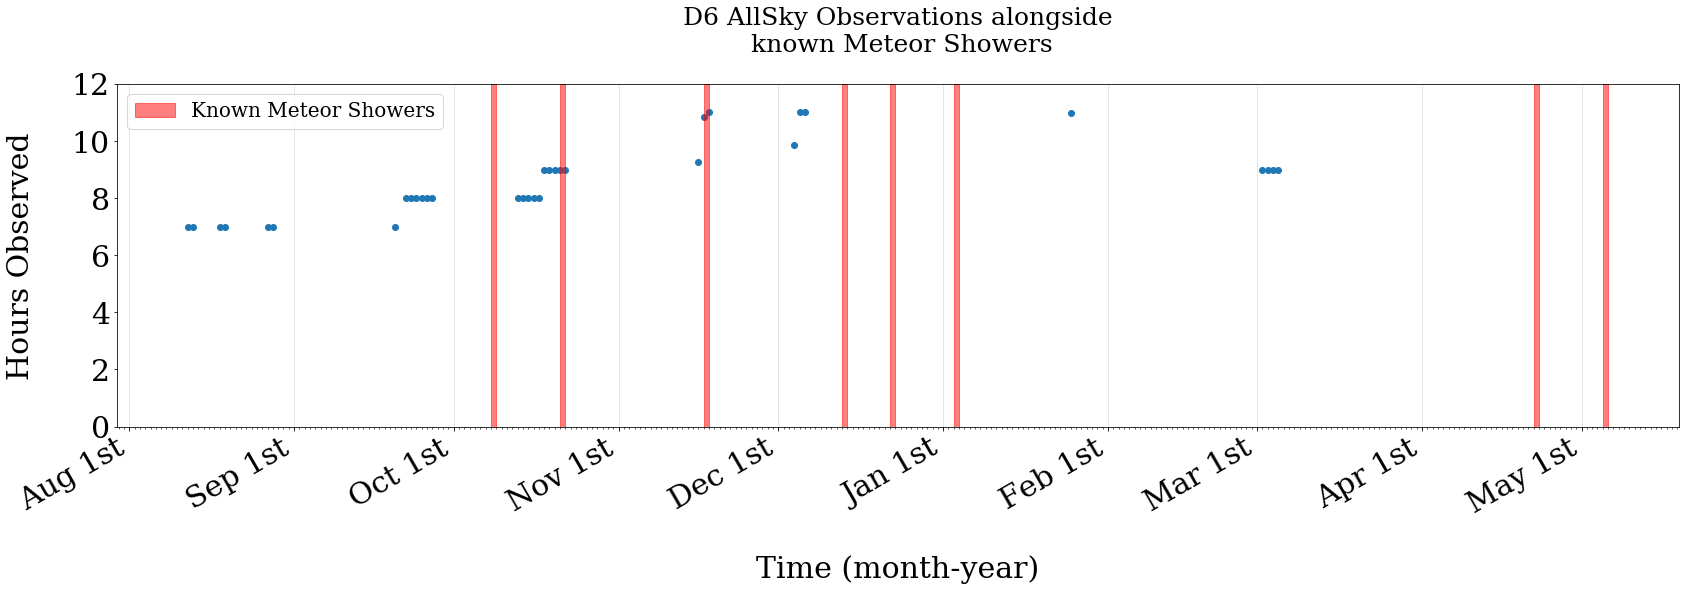

In [30]:
import matplotlib.dates as mdates

# Make beautiful plot

days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

fig = plt.figure(figsize=(28,7))
ax = plt.subplot(111)
plt.plot([],[])
plt.scatter(xvals,yvals)


plt.title('D6 AllSky Observations alongside\n known Meteor Showers\n', fontsize=25)

# beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%b 1st')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_minor_locator(days)
ax.set_ylim(0,12)
plt.locator_params(axis='y', nbins=6)
plt.grid(b=True, axis='x', alpha=0.4)

for i in np.arange(0,len(meteor_shower_xs)):
    if i == 0:
        showers = ax.axvspan(meteor_shower_xs[i], meteor_shower_ys[i],
               alpha=0.5, color='red', label='Known Meteor Showers')
    else:   
        showers = ax.axvspan(meteor_shower_xs[i], meteor_shower_ys[i],
               alpha=0.5, color='red')

plt.legend(loc='upper left', fontsize=20)
plt.xlabel('\nTime (month-year)')
plt.ylabel('Hours Observed\n')
    
plt.show()
plt.close()

#fig.savefig('images/nights_observed_with_meteorshowers.png', bbox_inches='tight')

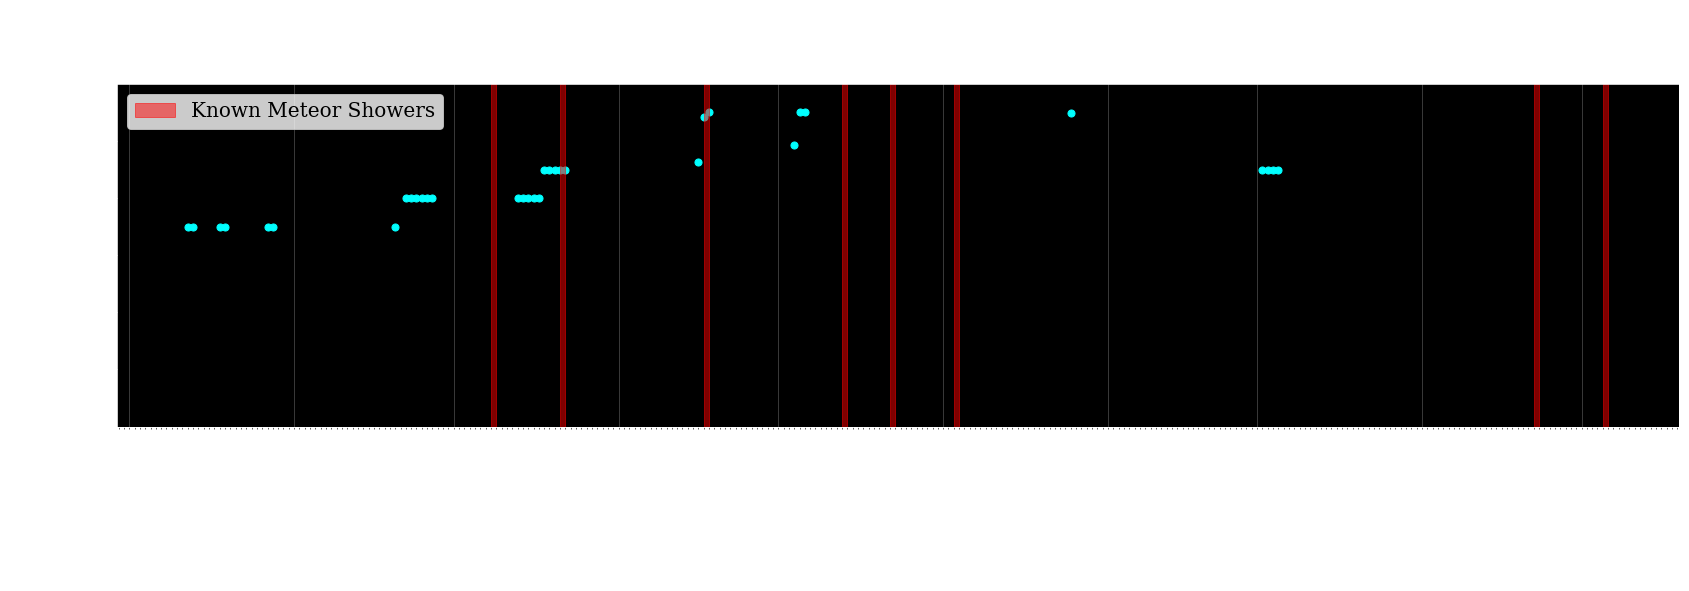

In [31]:
# Lets make the same plot in black lol

fig = plt.figure(figsize=(28,7))
ax = plt.subplot(111)
plt.plot([],[])
plt.scatter(xvals,yvals, color='cyan', s=50)


plt.title('D6 AllSky Observations alongside\n known Meteor Showers\n', fontsize=25, color='white')

# beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%b 1st')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_minor_locator(days)
ax.set_ylim(0,12)
plt.locator_params(axis='y', nbins=6)
plt.grid(b=True, axis='x', alpha=0.4)

for i in np.arange(0,len(meteor_shower_xs)):
    if i == 0:
        showers = ax.axvspan(meteor_shower_xs[i], meteor_shower_ys[i],
               alpha=0.5, color='red', label='Known Meteor Showers')
    else:   
        showers = ax.axvspan(meteor_shower_xs[i], meteor_shower_ys[i],
               alpha=0.5, color='red')


plt.legend(loc='upper left', fontsize=20)
plt.xlabel('\nTime (month-year)')
plt.ylabel('Hours Observed\n')

ax.set_facecolor('k')

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
    
plt.show()
plt.close()

#fig.savefig('images/nights_observed_with_meteorshowers_BLACK.png',facecolor=fig.get_facecolor(), transparent=True)

In [32]:
avg_area = np.average(np.concatenate(all_areas).ravel())
avg_flux = 6/avg_area/(total_time/60/60)
avg_flux

3.854968379549568e-07

In [34]:
total_time_hours = total_time/60/60
total_time_hours

277.8747222222222

In [40]:
brown_area = 2*np.pi*6374**2
brown_time = 365.25*24

brown_flux = (10**4)/brown_time/brown_area
brown_flux

4.468837338638608e-09

In [42]:
np.sum(np.array(long_nights['Tdif (seconds)'].astype(float)/60/60))

291.87388888888887

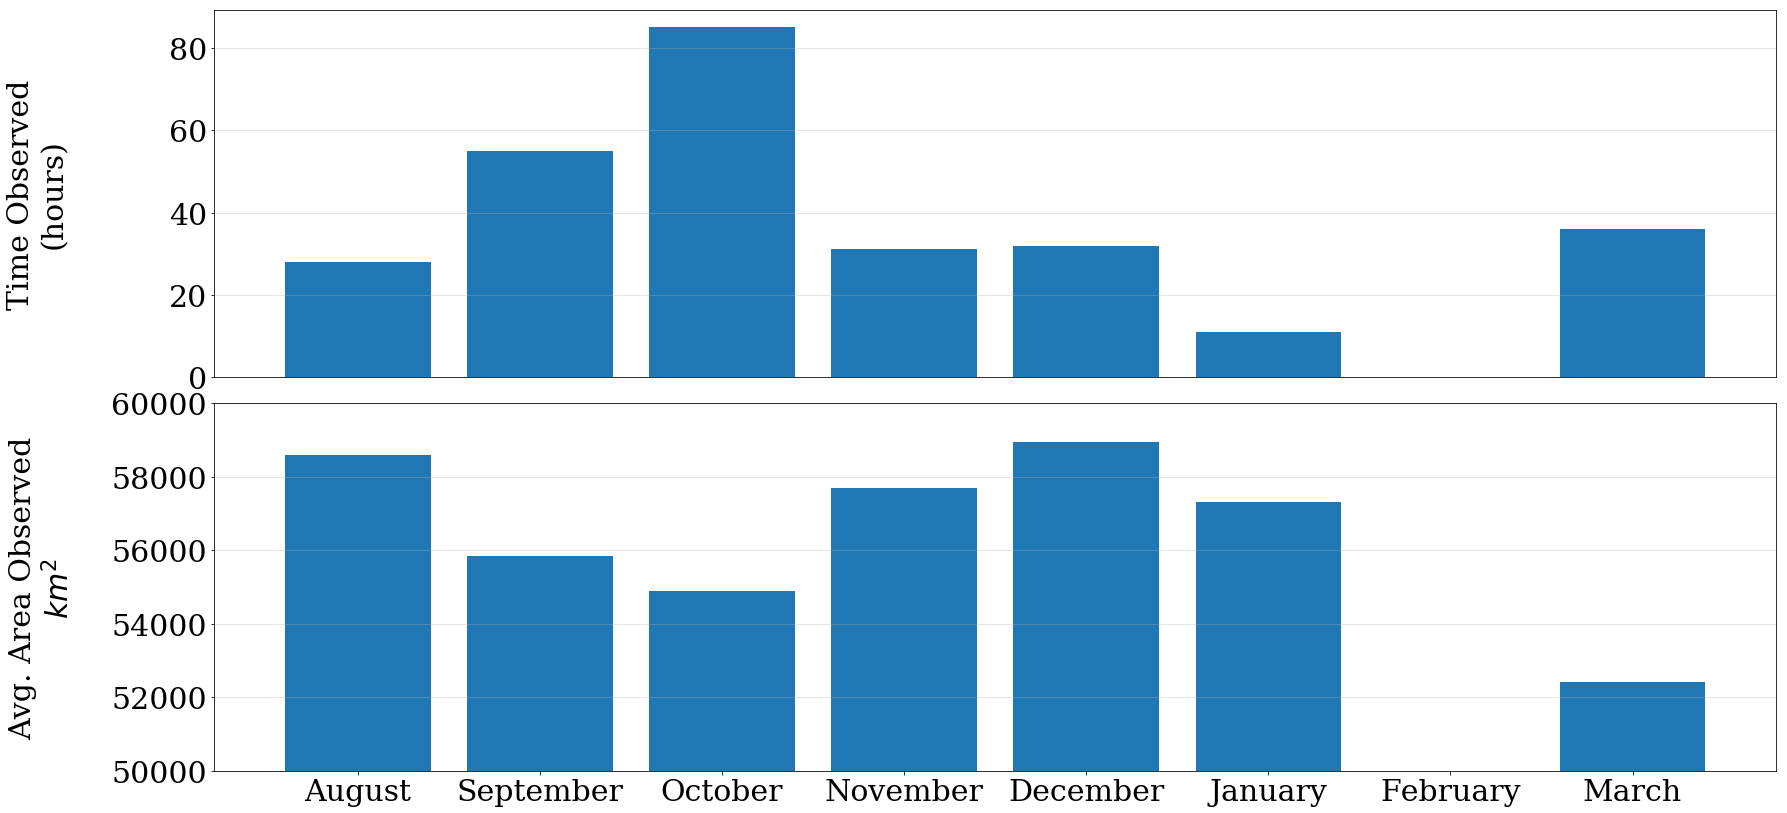

In [116]:
#######################################################################
# Plot bar plots for average area coverage and time observed
#######################################################################

# Get x vals
months = np.array(['August', 'September', 'October','November','December','January','February','March'])

# Get avg area per month
areas_unraveled = np.array([august_areas,september_areas,october_areas,november_areas,
                  december_areas,january_areas,february_areas,march_areas])

areas_avg_months = np.zeros(areas_unraveled.shape)

for i in np.arange(0,len(areas_unraveled)):
    if len(areas_unraveled[i])>0:
        avg = np.average(np.concatenate(areas_unraveled[i]).ravel())
    else:
        avg=0
    areas_avg_months[i] = avg
    
areas_avg_months = np.array(areas_avg_months)
    
# Get total time observed for each month

tot_month_times = np.array([august_time,september_time,october_time,november_time,
                  december_time,january_time,february_time,march_time])/3600

#########################################################################

fig = plt.figure(figsize=(28,14))

ax = plt.subplot(212)

plt.locator_params(axis='y', nbins=8)

monthcall = np.arange(1,len(months)+1)
plt.bar(monthcall,areas_avg_months)
#ax.axes.get_xaxis().set_visible(False)
ax.set_ylabel('Avg. Area Observed\n'+r'$km^2$'+'\n')
ax.set_ylim(50000,60000)
plt.grid(b=True, axis='y', alpha=0.4)

ax1 = plt.subplot(211,sharex = ax)
ax1.set_ylabel('Time Observed\n(hours)\n\n\n')
plt.grid(b=True, axis='y', alpha=0.4)
plt.locator_params(axis='y', nbins=5)

plt.bar(monthcall,tot_month_times)
plt.xticks(monthcall, months)
ax1.axes.get_xaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0.07)


plt.xlabel('\nMonth')

plt.show()

#fig.savefig('images/time_vs_areaobs_plot.png')

In [57]:
areas_unraveled = np.array([august_areas,september_areas,october_areas,november_areas,
                  december_areas,january_areas,february_areas,march_areas])

areas_avg_months = np.zeros(areas_unraveled.shape)

for i in np.arange(0,len(areas_unraveled)):
    if len(areas_unraveled[i])>0:
        avg = np.average(np.concatenate(areas_unraveled[i]).ravel())
    else:
        avg=0
    areas_avg_months[i] = avg

## Deleted Code:

Here are some things that might be useful to go back and realize how I established some of my methods.

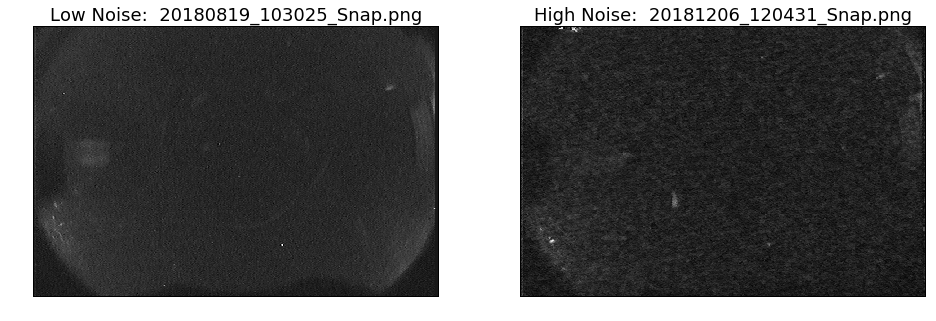

In [24]:
# List directory contents and create list of avi videos
path = '/home/pj/UsbStick/Video/'
dircontents = np.array(os.listdir(vidpath))

# Look at specific directory and scan it for png images
cond = [(file[-4:] == '.png') for file in dircontents]
onlypics = dircontents[cond]

#data = np.loadtxt('cloud_days.txt', dtype=str) 
#cond09 = np.invert([onlypics[i] in np.unique(np.array(data)[:,0]) for i in np.arange(0,len(onlypics))])
#onlypics = onlypics[cond09]

# Sort by date most recent
in_order = sorted(onlypics, key=lambda x: datetime.datetime.strptime(x, '%Y%m%d_%H%M%S_Snap.png'))
onlypics = in_order[::-1]
len(onlypics)


# Good 394, 442, 459, 560, 549
# Bad 16, 28, 47, 117

fig = plt.figure(figsize=(16,14))

ax1 = plt.subplot(121)

pic_good = cv2.imread(path+onlypics[549])
pic2_good = cv2.cvtColor(pic_good, cv2.COLOR_RGB2GRAY)
plt.imshow(pic2,cmap='gray')
plt.title('Low Noise:  '+str(onlypics[549]), fontsize=18)
plt.axis('off')

ax1 = plt.subplot(122)

pic_bad = cv2.imread(path+onlypics[117])
pic2_bad = cv2.cvtColor(pic_bad, cv2.COLOR_RGB2GRAY)
plt.imshow(pic2_bad,cmap='gray')
plt.title('High Noise:  '+str(onlypics[117]), fontsize=18)
plt.axis('off')

plt.show()

fig.savefig('images/low_and_high_noise.png', bbox_inches='tight')

In [ ]:
path = vidpath

for i in np.arange(0,len(onlypics)):
    
    pic = cv2.imread(path+onlypics[i])
    pic = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    unravel = pic.ravel()
    
    fig = plt.figure(figsize=(14,7))
    plt.suptitle(str(i)+'\nvidname: '+str(onlypics[i]))
    
    plt.subplot(121)
    plt.hist(unravel, 50, color='navy')
    boundsx = plt.xlim()[1] *0.8
    boundsy = plt.ylim()[1] *0.8
    med = np.median(unravel)
    #meds.append(med)
    plt.annotate(str(med),(boundsx,boundsy), size=20)

    
    plt.subplot(122)
    plt.imshow(pic, cmap='gray')
    
    
    plt.show()
    
    plt.figure(figsize=(14,4))
    
    ret3,th3 = cv2.threshold(pic,90,255,cv2.THRESH_BINARY)
    plt.subplot(121)
    plt.imshow(th3)
    plt.title('regular') 

    plt.subplot(122)
    plt.title('rectangle')
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    #kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel, iterations=1)
    opening = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=1)
    plt.imshow(opening)


    plt.show()

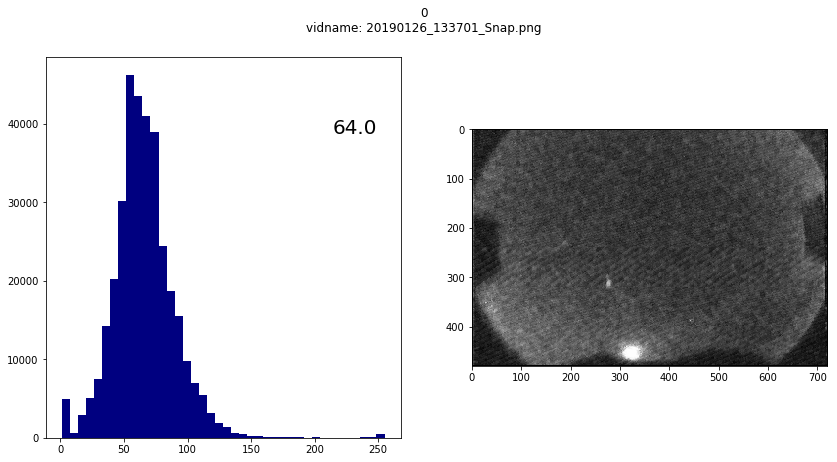

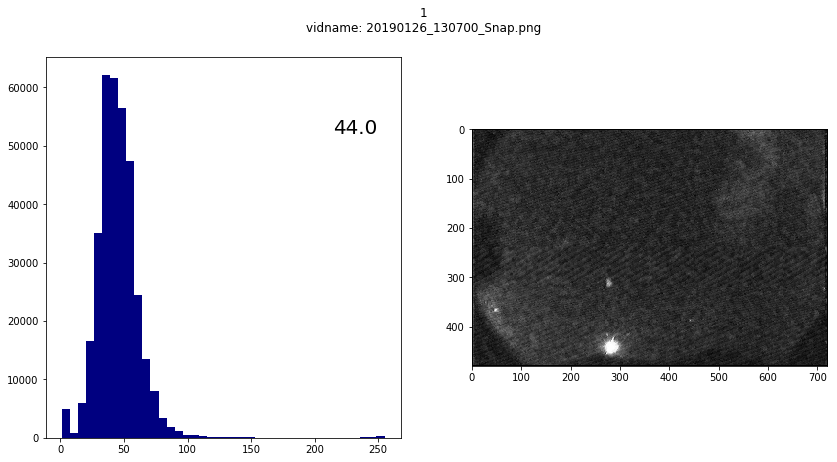

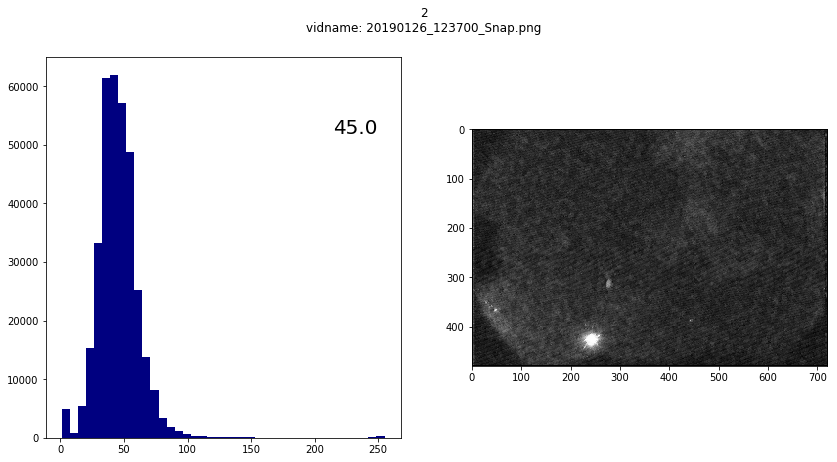

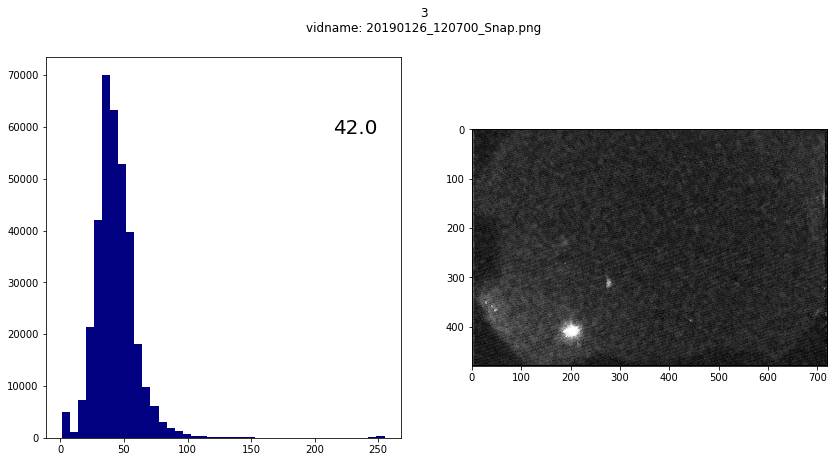

KeyboardInterrupt: 

In [88]:
path = vidpath
meds = []


for i in np.arange(0,len(onlypics)):
    pic = cv2.imread(path+onlypics[i])
    pic = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    unravel = pic.ravel()
    
    fig = plt.figure(figsize=(14,7))
    plt.suptitle(str(i)+'\nvidname: '+str(onlypics[i]))
    
    plt.subplot(121)
    plt.hist(unravel, 40, color='navy')
    boundsx = plt.xlim()[1] *0.8
    boundsy = plt.ylim()[1] *0.8
    med = np.median(unravel)
    meds.append(med)
    plt.annotate(str(med),(boundsx,boundsy), size=20)

    
    plt.subplot(122)
    plt.imshow(pic, cmap='gray')
    
    
    plt.show()

In [90]:
meds = np.array(meds)
index_list = np.arange(0,len(meds))
spec_cond = meds>60
special_list = index_list[spec_cond]


#for i in special_list: INSERT PLOTS HERE

### Pics for Thesis

In [36]:
# Specify directory you want to pull from
path = vidpath

# Create empty array to fill [vidname, angdist covered by clouds]
fillme = np.chararray((len(onlypics),2), itemsize = 30)
fillme[:] = '0'


#for i in np.arange(0,len(onlypics)):
for i in np.arange(224,225):
    
    # Identify pic
    pic = cv2.imread(path+onlypics[i])
    
    # Convert to grayscale
    pic = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    
    # Threshold it at 90
    ret3,th3 = cv2.threshold(pic,90,255,cv2.THRESH_BINARY)
    
    extended = th3.ravel()
    
    if 1==1:
    #if np.median(extended)>90:

        xs = []
        ys = []
        zs = []
        
        print('yes')
        # Use 5x5 kernal in morpohology close and erode
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

        # Close up any small gaps in clouds and then open back up other areas
        closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel, iterations=2)
        opening = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=2)

        # Initialize sum of angular distance covered by clouds

        for j in np.arange(0,len(opening)):
            for k in np.arange(0,len(opening[0])):
                # If we have a 'cloud pixel' ---> do stuff
                if (opening[j,k] != 0):
                    # Add contribution specific to respective small square
                    box_x = divmod(k,40)[0]
                    box_y = divmod(j,40)[0]
                    contribution = empty[box_y,box_x]
                    colornum = (contribution/max(empty.ravel()))*255
                    xs.append(k)
                    ys.append(j)
                    zs.append(int(colornum))
        

yes


In [37]:
max(empty.ravel())

0.24915820750958914

In [ ]:
path = vidpath
figz=[]

for i in np.arange(0,len(onlypics)):
    
    # Identify pic
    pic = cv2.imread(path+onlypics[i])
    
    # Convert to grayscale
    pic = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    
    # Threshold it at 90
    ret3,th3 = cv2.threshold(pic,90,255,cv2.THRESH_BINARY)
    
    extended = pic.ravel()
    figz.append(np.median(extended))
    
    if (100<np.median(extended)):
        
        print('yes')
        # Use 5x5 kernal in morpohology close and erode
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

        # Close up any small gaps in clouds and then open back up other areas
        closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel, iterations=1)
        opening = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=1)
        plt.imshow(opening,cmap='gray')
        plt.title(str(i))
        plt.show()
        plt.imshow(pic,cmap='gray')
        plt.show()

In [38]:
path = vidpath

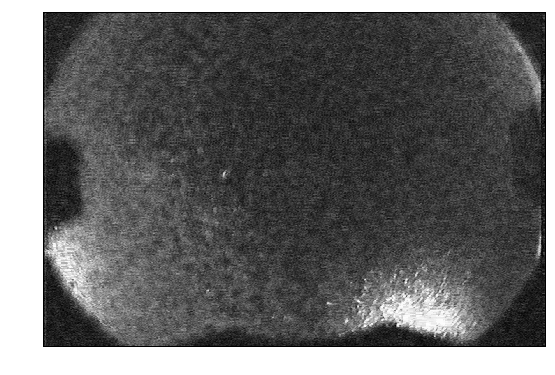

In [42]:
fig = plt.figure(figsize=(9,7))

pic = cv2.imread(path+onlypics[224])
pic = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
ret3,th3 = cv2.threshold(pic,90,255,cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

# Close up any small gaps in clouds and then open back up other areas
closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel, iterations=1)
opening = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=1)
#for i in np.arange(0,len(pic),40):
#    plt.axhline(y=i,color='white',linewidth=1)
#for i in np.arange(0,len(pic[0]),40):
#    plt.axvline(x=i,color='white',linewidth=1)


plt.axis('off')
plt.imshow(pic, cmap='gray')
plt.show()

fig.savefig('regpic_withOUTgrid.png', facecolor='k', transparency=True)

In [43]:
len(pic)

480

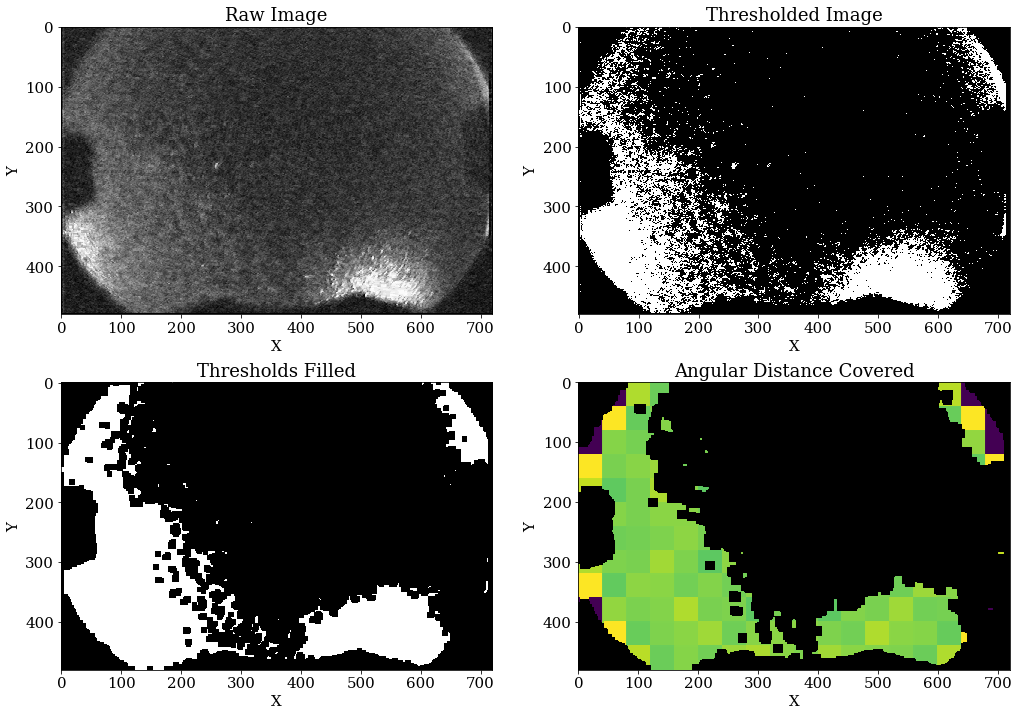

In [45]:
fig = plt.figure(figsize=(17,12))


ax1 = fig.add_subplot(2, 2, 1) # nrows, ncols, index
ax1.set_title('Raw Image')
plt.imshow(pic, cmap='gray', aspect=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

#############################################################################

ax2 = fig.add_subplot(2, 2, 2) # nrows, ncols, index
ax2.set_title('Thresholded Image')
plt.imshow(th3, cmap='gray', aspect=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

#############################################################################

ax3 = fig.add_subplot(2, 2, 3) # nrows, ncols, index
ax3.set_title('Thresholds Filled')
plt.imshow(opening, cmap='gray')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')

#############################################################################3

ax4 = fig.add_subplot(2, 2, 4) # nrows, ncols, index
ax4.set_title('Angular Distance Covered')
plt.scatter(xs,ys, color= cm.viridis(zs), marker='s', s=1)
ax4.set_aspect('equal')
plt.ylim(480,0)
plt.xlim(0,720)
ax4.set_facecolor('k')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')

#############################################################################

pylab.rc('font', family='serif', size=15)


plt.show()

fig.savefig('images/Cloud_analysis.png', bbox_inches='tight')

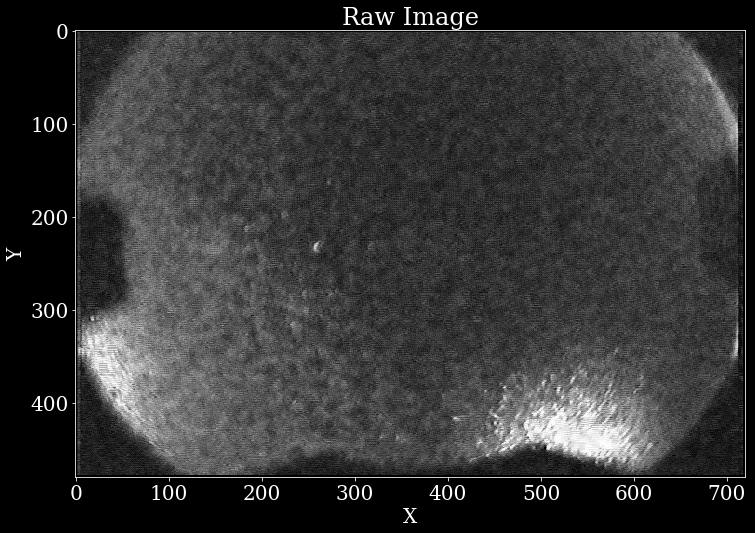

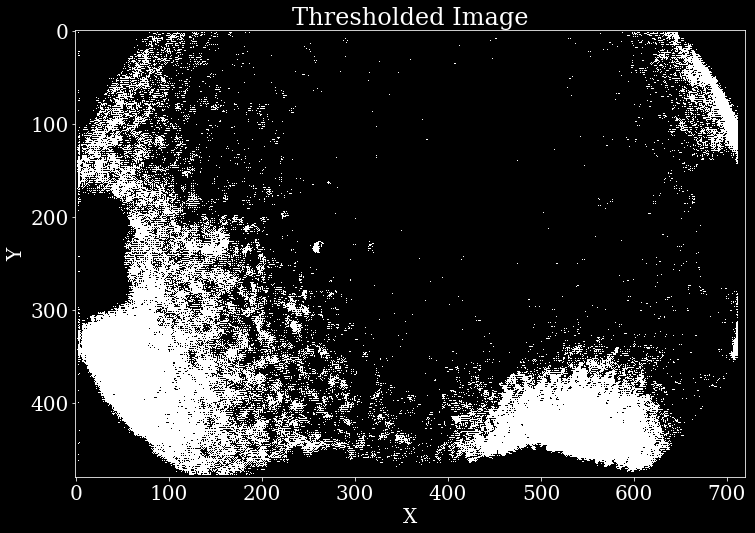

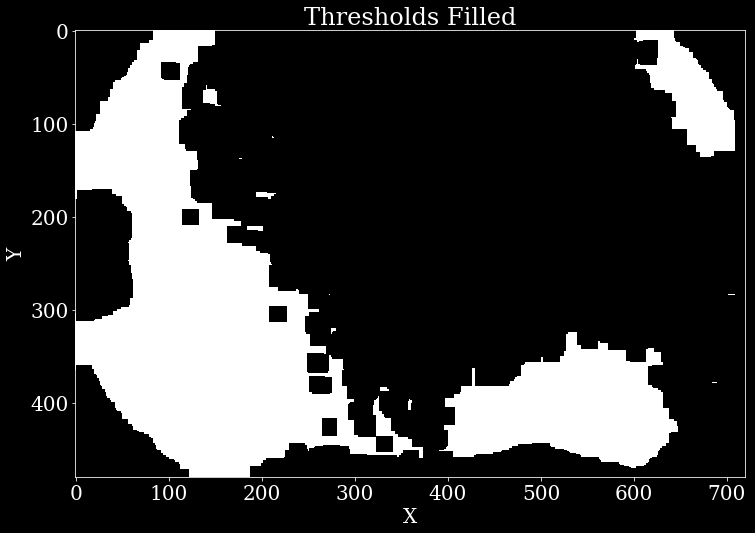

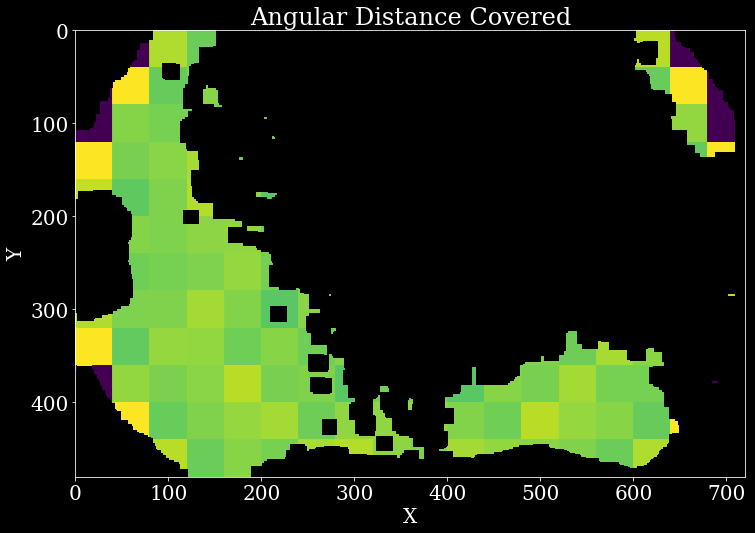

In [48]:



fig = plt.figure(figsize=(12,12))

fig.patch.set_facecolor('black')

ax1 = fig.add_subplot(1, 1, 1) # nrows, ncols, index
ax1.spines['bottom'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.xaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white')
ax1.yaxis.label.set_color('white')
ax1.tick_params(axis='y', colors='white')
ax1.set_title('Raw Image', color='white')
plt.imshow(pic, cmap='gray', aspect=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

pylab.rc('font', family='serif', size=20)
plt.show()
fig.savefig('images/Cloud_analysis_white1.png', facecolor=fig.get_facecolor(), transparent=True)

#############################################################################



fig = plt.figure(figsize=(12,12))

fig.patch.set_facecolor('black')

ax2 = fig.add_subplot(1, 1, 1) # nrows, ncols, index
ax2.spines['bottom'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.xaxis.label.set_color('white')
ax2.tick_params(axis='x', colors='white')
ax2.yaxis.label.set_color('white')
ax2.tick_params(axis='y', colors='white')

ax2.set_title('Thresholded Image', color='white')
plt.imshow(th3, cmap='gray', aspect=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')


pylab.rc('font', family='serif', size=20)
plt.show()
fig.savefig('images/Cloud_analysis_white2.png', facecolor=fig.get_facecolor(), transparent=True)


#############################################################################

fig = plt.figure(figsize=(12,12))

fig.patch.set_facecolor('black')

ax3 = fig.add_subplot(1, 1, 1) # nrows, ncols, index
ax3.set_title('Thresholds Filled', color='white')
plt.imshow(opening, cmap='gray')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')

fig.patch.set_facecolor('black')
ax3.spines['bottom'].set_color('white')
ax3.spines['top'].set_color('white')
ax3.spines['left'].set_color('white')
ax3.spines['right'].set_color('white')
ax3.xaxis.label.set_color('white')
ax3.tick_params(axis='x', colors='white')
ax3.yaxis.label.set_color('white')
ax3.tick_params(axis='y', colors='white')
pylab.rc('font', family='serif', size=20)
fig.savefig('images/Cloud_analysis_white3.png', facecolor=fig.get_facecolor(), transparent=True)

plt.show()
fig.savefig('images/Cloud_analysis_white3.png', facecolor=fig.get_facecolor(), transparent=True)


#############################################################################3

fig = plt.figure(figsize=(12,12))

fig.patch.set_facecolor('black')

ax4 = fig.add_subplot(1, 1, 1) # nrows, ncols, index

ax4.set_title('Angular Distance Covered', color='white')
plt.scatter(xs,ys, color= cm.viridis(zs), marker='s', s=1)
ax4.set_aspect('equal')
plt.ylim(480,0)
plt.xlim(0,720)
ax4.set_facecolor('k')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')

ax4.spines['bottom'].set_color('white')
ax4.spines['top'].set_color('white')
ax4.spines['left'].set_color('white')
ax4.spines['right'].set_color('white')
ax4.xaxis.label.set_color('white')
ax4.tick_params(axis='x', colors='white')
ax4.yaxis.label.set_color('white')
ax4.tick_params(axis='y', colors='white')

pylab.rc('font', family='serif', size=20)
plt.show()
fig.savefig('images/Cloud_analysis_white4.png', facecolor=fig.get_facecolor(), transparent=True)

#############################################################################

############################################



#############################################
#pylab.rc('font', family='serif', size=15)


#plt.show()

#fig.savefig('images/Cloud_analysis_white.png', facecolor=fig.get_facecolor(), transparent=True)

In [65]:
path = '/home/pj/UsbStick/Video/'

In [63]:
onlypics[i]

'20181207_080448_Snap.png'

In [64]:
path

'/home/pj/UsbStick/Video'

In [29]:
pd.read_csv('/home/pj/Documents/Thesis/clouds/2019-03-03_2019-03-04')

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,timestamps,2019-03-04 04:00:04+00:00,2019-03-04 12:30:58+00:00,2019-03-04 08:30:57+00:00,2019-03-04 11:00:58+00:00,2019-03-04 09:30:57+00:00,2019-03-04 04:00:55+00:00,2019-03-04 06:00:56+00:00,2019-03-04 12:00:58+00:00,2019-03-04 04:30:55+00:00,...,2019-03-04 06:30:56+00:00,2019-03-04 10:00:57+00:00,2019-03-04 07:00:56+00:00,2019-03-04 11:30:58+00:00,2019-03-04 10:30:57+00:00,2019-03-04 05:00:55+00:00,2019-03-04 05:30:56+00:00,2019-03-04 09:00:57+00:00,2019-03-04 08:00:57+00:00,2019-03-04 13:00:00+00:00
1,area_observed_(km^2),0.0,54741.671352938254,54770.302446632704,54789.950191348915,54774.46636089175,54740.814907523476,54736.212369964924,54768.39273526567,54749.80847474633,...,54746.15703298168,54778.261139881746,54750.70194142353,54798.300433006785,54769.44097986311,54719.38685772845,54738.69424320015,54792.526274723175,54767.71351509473,0.0
2,time_with_coverage (seconds),0.0,66653.5,40500.0,45000.0,73798.5,36899.5,14401.5,40499.5,35099.0,...,47700.5,44100.0,45900.5,49500.5,74698.5,34199.5,7201.0,47700.5,59343.0,0.0
